In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re, string
#from textblob import TextBlob
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
len(df_train)

159571

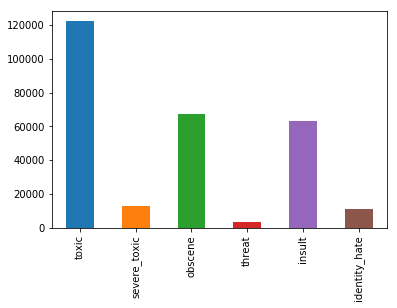

In [38]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_train[label_cols].sum().plot.bar()

In [5]:
df_train['category'] = df_train[label_cols].max(axis=1)

In [22]:
count_toxic = df_train['category'].sum()#df_train[df_train['category'] != 0].count     #.sum
count_toxic

129800

In [23]:
percentage_toxic = float(count_toxic)/len(df_train)
print(percentage_toxic*100)

47.520373719549255


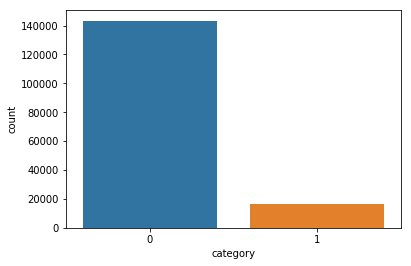

In [8]:
sns.countplot(df_train['category'])

As we can see, there are only 10% of toxic comments available in the training dataset. This shows class imbalance between non-toxic and toxic comments(which includes all labels)
So, let's try to increase the number of samples in toxic category and see the results.

In [9]:
df_train['comment_text'].notna().sum()

159571

In [10]:
df_train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
category         False
dtype: bool

Increasinng the sampling by appending the toxic comment back to training dataset

In [19]:
df_train_resample = df_train[df_train['category'] == 1]
df_train_resample.shape

(64900, 9)

In [20]:
df_train_resample.reset_index(drop=True, inplace=True)
df_train_resample.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category
0,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
1,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
2,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
3,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,1
4,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1


In [21]:
df_train = pd.concat([df_train, df_train_resample])
df_train.shape

(273146, 9)

In [24]:
df_train.category.sum()

129800

In [25]:
df_train.shape

(273146, 9)

Let's implement the ML models now..

In [26]:
#Removing unecessary punctutation from the comments
re_tok = re.compile("([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [27]:
n = df_train.shape[0]
# sublinear_tf = True -> To use a logarithmic form of Frequency
# min_df = 3          -> minimum numbers of documents a word must be present in to be kept
# norm = l2           -> to ensure all our feature vectors have a euclidian norm of 1
# stop_words = 'english' -> As we're dealing with English comments, removing the stopwords for model to be efficient
vec = TfidfVectorizer( ngram_range=(1,1),       tokenizer=tokenize,
                       min_df=5,                max_df=0.9, 
                       strip_accents='unicode', use_idf=1,
                       smooth_idf=1,            sublinear_tf=1, 
                       norm = 'l2',             stop_words='english' )

In [28]:
train_features = vec.fit_transform(df_train['comment_text'])
test_features = vec.transform(df_test['comment_text'])

In [29]:
train_features.shape, test_features.shape

((273146, 12360), (153164, 12360))

In [30]:
model = LogisticRegression(C=4, dual=True)

In [31]:
predictions_df = np.zeros((len(df_test), len(label_cols)))
for i, col in enumerate(label_cols):
    print("fit: ", col)
    classifier = model.fit(train_features, df_train[col].values)
    predictions_df[:,i] = classifier.predict_proba(test_features)[:,1]
    #pred_df = pd.DataFrame(predictions)
    print(predictions_df.shape)

fit:  toxic
(153164, 6)
fit:  severe_toxic
(153164, 6)
fit:  obscene
(153164, 6)
fit:  threat
(153164, 6)
fit:  insult
(153164, 6)
fit:  identity_hate
(153164, 6)


In [32]:
for col in label_cols:
    accuracy = cross_val_score(model, train_features, df_train[col].values, scoring='accuracy', cv=5)
    print(col, ": ", accuracy.mean())

toxic :  0.8146484411716397
severe_toxic :  0.9617676785755733
obscene :  0.8587565082002337
threat :  0.9886983517012584
insult :  0.8503070785231545
identity_hate :  0.9674093652218353


LSTM

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train[label_cols], test_size = 0.20, random_state = 42)

In [34]:
list_sentences_train = X_train["comment_text"]
list_sentences_test = X_test["comment_text"]

In [35]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features,char_level=True)

In [36]:
tokenizer.fit_on_texts(list(list_sentences_train))

In [37]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [39]:
maxlen = 500
X_tr = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [40]:
#Input layer
inp = Input(shape=(maxlen, ))

In [41]:
#Embedding Layer
embed_size = 240
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)

In [42]:
#LSTM layer
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)

In [43]:
x = GlobalMaxPool1D()(x)

In [44]:
x = Dense(6, activation="sigmoid")(x)

In [45]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 240)          505920    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 120)          108360    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 726       
Total params: 615,006
Trainable params: 615,006
Non-trainable params: 0
_________________________________________________________________


In [48]:
batch_size = 100
epochs = 2

hist = model.fit(X_tr,y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_te,y_test))

Train on 218516 samples, validate on 54630 samples
Epoch 1/2
218516/218516 [==============================] - 7780s 36ms/step - loss: 0.2309 - acc: 0.9070 - val_loss: 0.2033 - val_acc: 0.9180
Epoch 2/2
218516/218516 [==============================] - 7673s 35ms/step - loss: 0.1860 - acc: 0.9247 - val_loss: 0.1722 - val_acc: 0.9300
